In [34]:
from numpy import zeros, array, clip, trunc
import numpy as np
from math import pi, cos, sqrt, log10
from cv2 import imread, imwrite, imshow, waitKey, destroyAllWindows, cvtColor, COLOR_BGR2RGB
import cv2 
from skimage.metrics import structural_similarity as ssim
import sys, time
import matplotlib.pyplot as plt

In [35]:
from skimage import data
from skimage.color import rgb2gray
from skimage import img_as_ubyte,img_as_float
from PIL import Image
from numpy.linalg import svd
from ipywidgets import interact,interactive,interact_manual

In [36]:
from ipywidgets import interact,interactive,interact_manual
from skimage import data
from skimage.color import rgb2gray
from skimage import img_as_ubyte,img_as_float
from PIL import Image
import ipywidgets as widgets

In [33]:
path1 = 'parrotimg.jpg'
img = Image.open(path1)
path2 = '4kimage_1.jpg'
img2 = Image.open(path2)

# SVD

In [37]:
def compress_svd(image,k):
    """
    Perform svd decomposition and truncated (using k singular values/vectors) reconstruction
    returns
    --------
      reconstructed matrix reconst_matrix, array of singular values s
    """
    U,s,V = svd(image,full_matrices=False)
    reconst_matrix = np.dot(U[:,:k],np.dot(np.diag(s[:k]),V[:k,:]))
   
    return reconst_matrix,s

# DCT

In [38]:

cos_backup = array([])
def cos_values(N):
    ret = zeros((N,N))
    for n in range(len(ret)):
        for k in range(len(ret[n])):
            ret[k,n] = cos(((pi*k)*(2*n+1))/(2*N))
    global cos_backup
    cos_backup = ret
    
def direct_dct(vector):
    N = len(vector)
    if len(cos_backup) != N:
        cos_values(N)
    vector = cos_backup.dot(vector)
    vector[0] = vector[0] * sqrt(1/2)
    vector = vector * sqrt(2/N)
    return vector

def inverse_dct(vector):
    N = len(vector)
    if len(cos_backup) != N:
        cos_values(N)
    vector[0] = vector[0] * sqrt(1/2)
    vector = vector * sqrt(2/N)
    return cos_backup.T.dot(vector)

def direct_dct_2d(matrix):
    Nx,Ny = matrix.shape
    for line in range(Nx):
        matrix[line] = direct_dct(matrix[line])
    for column in range(Ny):
        matrix[:,column] = direct_dct(matrix[:,column])
    return matrix

def inverse_dct_2d(matrix):
    Nx,Ny = matrix.shape
    for column in range(Ny):
        matrix[:,column] = inverse_dct(matrix[:,column])
    for line in range(Nx):
        matrix[line] = inverse_dct(matrix[line])
    return matrix

def direct_dct_image(img):
    if img.shape[2] == 3:
        for i in range(3):
            img[:,:,i] = direct_dct_2d(img[:,:,i])
    else:
        img[:, :, 0] = direct_dct_2d(img[:, :,0])
    return img

def inverse_dct_image(img):
    if img.shape[2] == 3:
        for i in range(3):
            img[:,:,i] = inverse_dct_2d(img[:,:,i])
    else:
        img[:, :, 0] = inverse_dct_2d(img[:, :,0])
    return img.clip(0, 255)

def remove_coeficients_from_image(img, keep):

    img_new = np.zeros(img.shape)

    for i in range(keep * 3): # * 3, because 3 color channels
        index = np.unravel_index(np.absolute(img).argmax(), img.shape)
        img_new[index] = img[index] # copy it over to new image
        img[index] = 0 # remove from original so we don't count it again
        
    return img_new


# Performance Metrics

In [39]:
def compression_time():
    return time.time() - start_time

In [40]:
def compression_ratio(original_img_arr, compressed_img_arr):
    
    #cv2.imwrite(f"resizeoutput.jpg", compressed_img_arr)
    compressed_size = sys.getsizeof(compressed_img_arr)
    original_size = sys.getsizeof(original_img_arr)
    compression_ratio = original_size/compressed_size
    #compression_ratio = round(os.stat("parrotimg.jpg").st_size/1024)/round(os.stat("resizeoutput.jpg").st_size/1024)

    return compression_ratio

In [41]:
def get_mse(original_img_arr, decoded_img_arr):
    
    mse = np.sum((original_img_arr.astype("float") - decoded_img_arr.astype("float")) ** 2)
    mse /= float(original_img_arr.shape[0] * decoded_img_arr.shape[1])
    
    return mse

In [42]:
def get_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal ==> PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [43]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def get_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')
        

# Performance and Evaluation of SVD on 4k images

In [44]:
color_images = {
    "parrot":img_as_float(img),
    "mountain":img_as_float(img2)
    
}

In [57]:
def compress_show_color_images_reshape(img_name,k):
    """
     compress and display the reconstructed color image using the reshape method 
    """
    image = color_images[img_name]
    original_shape = image.shape
    image_reshaped = image.reshape((original_shape[0],original_shape[1]*3))
    image_reconst,_ = compress_svd(image_reshaped,k)
    image_reconst2 = image_reconst.reshape(original_shape)
    compression_ratio =100.0* (k*(original_shape[0] + 3*original_shape[1])+k)/(original_shape[0]*original_shape[1]*original_shape[2])
    plt.title("Compression Ratio = {}\nMean Square Error = {}\nPeak Signal to Noise Ratio = {}\nStructural Similarity Index Measure = {}".format(compression_ratio,get_mse(image, image_reconst2),get_psnr(image, image_reconst2),get_ssim(image, image_reconst2)))
    plt.imshow(image_reconst2)
    #print("Compression Ratio = {.2f}\nMean Square Error = {.2f}\nPeak Signal to Noise Ratio = {.2f}\nStructural Similarity Index Measure = {.2f}".format(compression_ratio(img, enc),get_mse(img, enc),get_psnr(img,enc),get_ssim(img, enc)))

In [58]:
list_widget = widgets.Dropdown(options=list(color_images.keys()))
int_slider_widget = widgets.IntSlider(value=20,min=1,max=500)


interactive(children=(Dropdown(description='img_name', options=('parrot', 'mountain'), value='parrot'), IntSli…

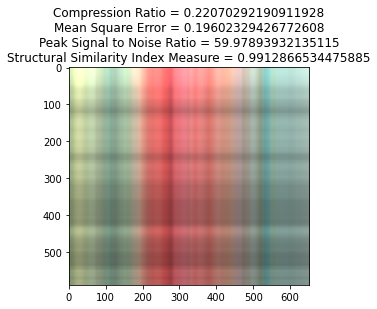

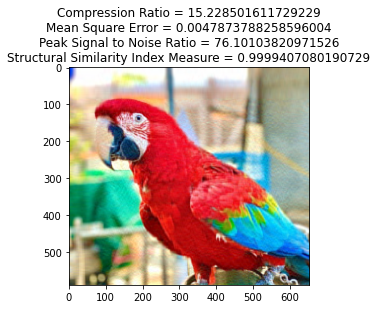

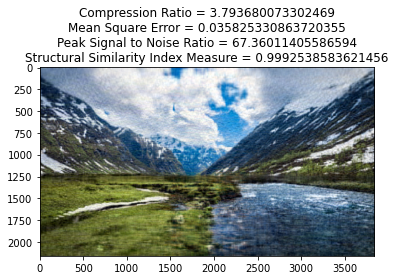

In [59]:
interact(compress_show_color_images_reshape,img_name=list_widget,k=int_slider_widget);

# Performance and Evaluation of DCT on 4k images

In [61]:
dct_images = {
    "parrot":imread(path1),
    "mountain":imread(path2)
}

In [68]:
def compress_show_images(img_name,k):
   
    img = dct_images[img_name]
    img = img.astype('float64')
    x = direct_dct_image(img.copy())  
    y = remove_coeficients_from_image(x.copy(), k)
    enc = cvtColor(inverse_dct_image(y).astype('uint8'), COLOR_BGR2RGB)
    
    plt.title("Compression Ratio = {}\nMean Square Error = {}\nPeak Signal to Noise Ratio = {}\nStructural Similarity Index Measure = {}".format(compression_ratio(img, enc),get_mse(img, enc),get_psnr(img,enc),get_ssim(img, enc)))
    plt.imshow(enc)
  

In [69]:
#setting dropdown and slider
list_widget = widgets.Dropdown(options=list(dct_images.keys()))
int_slider_widget = widgets.IntSlider(value=100,min=1,max=2000)


interactive(children=(Dropdown(description='img_name', options=('parrot', 'mountain'), value='parrot'), IntSli…

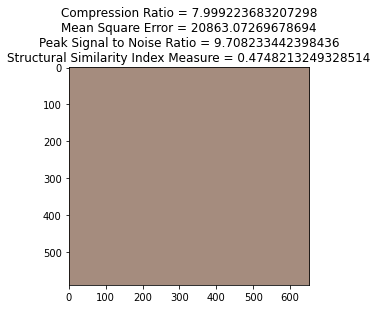

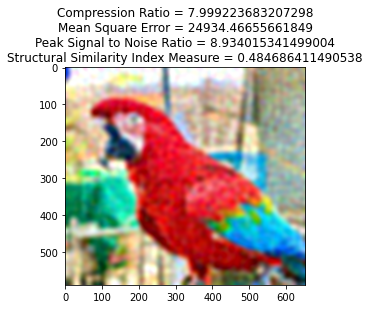

In [70]:
interact(compress_show_images,img_name=list_widget,k=int_slider_widget);